# Nicotine Side Learning Y-maze

## Load packages

In [2]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [3]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [4]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "6") # Subset for Nicotine experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
1413,17.05.22,09:01,Laura Neubauer,24.5,26th January - Spain,5-days,35,36,1,2,⋯,14,519,12,NA,NA,6,0,0,0,0-30


## Ensure relevant variables are factors

In [5]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [6]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 17.05.22 19.05.22 20.05.22 23.05.22 24.05.22 25.05.22 26.05.22 27.05.22
8 Levels: 17.05.22 19.05.22 20.05.22 23.05.22 24.05.22 25.05.22 ... 27.05.22

[1] Laura Neubauer
Levels: Laura Neubauer

[1] 5-days 4-days 3-days
Levels: 3-days 4-days 5-days

[1] 35_36 58_59 60_61
Levels: 35_36 58_59 60_61

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64
64 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 64

## Do initial and final choices significantly differ?

In [7]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.971 0.236 Inf    1  -0.121  0.9034

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [8]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [9]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [10]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [11]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [12]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [13]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [14]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Model Selection

In [15]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,12,283.6619,0.000000,1.00000000,0.57921441,-129.1890,0.5792144
7,max_mod,16,286.7407,3.078730,0.21451724,0.12425147,-126.2323,0.7034659
6,solution_time_mod,15,287.2960,3.634021,0.16251086,0.09412863,-127.6480,0.7975945
3,solution_mod,10,287.6940,4.032058,0.13318326,0.07714166,-133.3980,0.8747362
4,side_mod,10,288.3204,4.658498,0.09736885,0.05639744,-133.7112,0.9311336
1,null_mod,9,288.5402,4.878313,0.08723439,0.05052741,-134.9043,0.9816610
5,tsm_mod,10,290.5672,6.905289,0.03166180,0.01833897,-134.8346,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,12,283.6619,0.000000,1.00000000,0.57921441,-129.1890,0.5792144
7,max_mod,16,286.7407,3.078730,0.21451724,0.12425147,-126.2323,0.7034659
6,solution_time_mod,15,287.2960,3.634021,0.16251086,0.09412863,-127.6480,0.7975945
3,solution_mod,10,287.6940,4.032058,0.13318326,0.07714166,-133.3980,0.8747362
4,side_mod,10,288.3204,4.658498,0.09736885,0.05639744,-133.7112,0.9311336
1,null_mod,9,288.5402,4.878313,0.08723439,0.05052741,-134.9043,0.9816610


**The visit_mod explains 58% of the total variance explained by all of the models tested.**

In [16]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'visit_mod' and 'max_mod':
4.66

The visit model is 5 times more parsimonious than the next "best" model (max_mod).

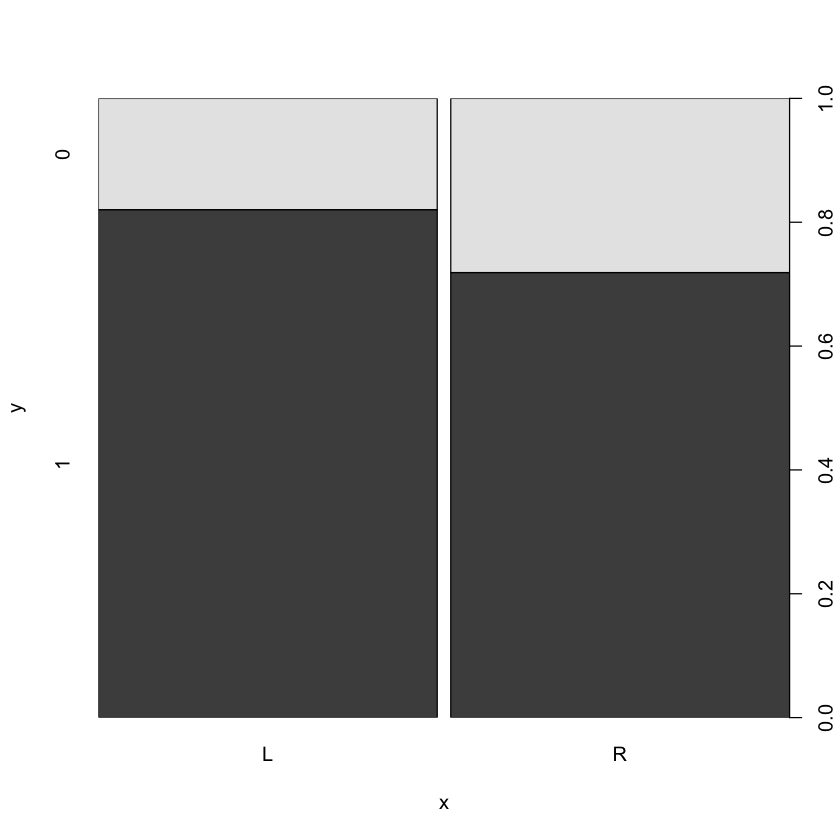

In [17]:
plot(ELP$Reward_Side, ELP$Final_Binary)

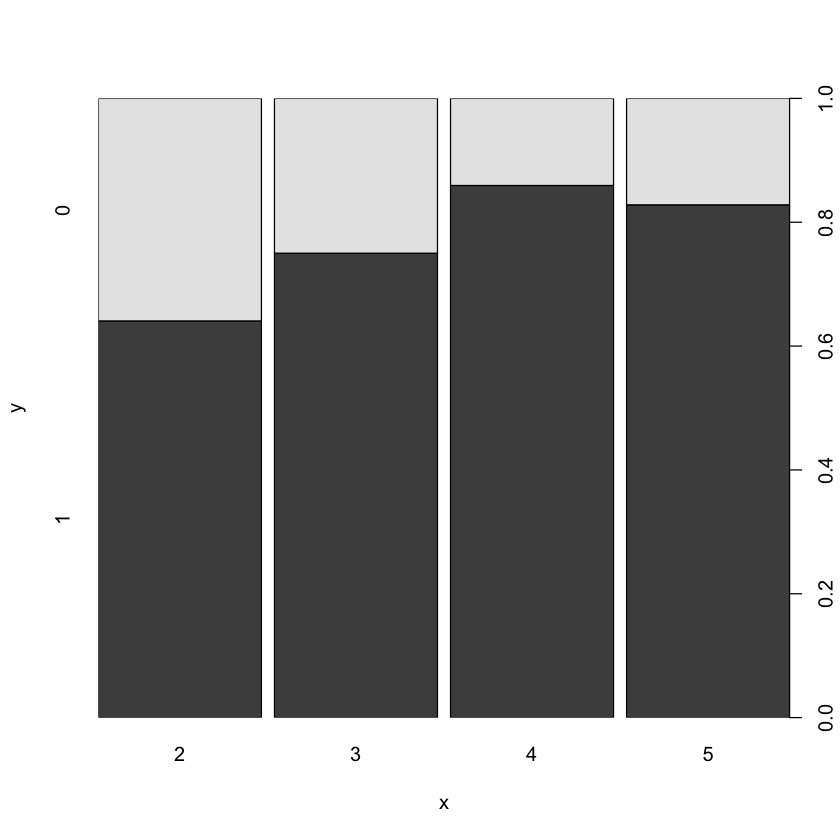

In [18]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Consecutive visits seems to increase the number of ants choosing the reward side.
- There seems to be a very slight side bias towards the Left.

## Brain lateralisation VS Visual Cues
**This setup had the wall on the Right!**

## Model averaging

In [19]:
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,visit_mod,12,283.6619,0.000000,1.00000000,0.57921441,-129.1890,0.5792144
7,max_mod,16,286.7407,3.078730,0.21451724,0.12425147,-126.2323,0.7034659
6,solution_time_mod,15,287.2960,3.634021,0.16251086,0.09412863,-127.6480,0.7975945
3,solution_mod,10,287.6940,4.032058,0.13318326,0.07714166,-133.3980,0.8747362
4,side_mod,10,288.3204,4.658498,0.09736885,0.05639744,-133.7112,0.9311336
1,null_mod,9,288.5402,4.878313,0.08723439,0.05052741,-134.9043,0.9816610


There is no clearly better model!

In [21]:
top_models = list("visit_mod" = visit_mod, 
                   "max_mod" = max_mod,
                   "solution_time_mod" = solution_time_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "null_mod" = null_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavg(top_models, parm = "SolutionNicotine", exclude = "SolutionNicotine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Visit3")
modavgShrink(top_models, parm = "Visit4")
modavgShrink(top_models, parm = "Visit5")
modavg(top_models, parm = "TSM_Bin31-60", exclude = "SolutionNicotine:TSM_Bin31-60")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "SolutionNicotine:TSM_Bin31-60")

Warning message in modavgShrink.AICglmerMod(top_models, parm = "(Intercept)"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,0.8828745,0.4723553
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,1.2170319,0.5272329
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,1.1044540,0.4991045
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,1.8293643,0.4351237
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,1.7737162,0.4433144
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,1.5481181,0.3992679


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max_mod,16,286.7407,0.0000000,1.0000000,0.4204478,-126.2323,-0.4855280,0.5046182
solution_time_mod,15,287.2960,0.5552906,0.7575655,0.3185167,-127.6480,-0.4876039,0.5235633
solution_mod,10,287.6940,0.9533281,0.6208511,0.2610355,-133.3980,-0.6094866,0.3469903


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit3"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,0.6091054,0.4232808
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,0.6043459,0.4215980
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,0.6075310,0.4226981
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,0.0000000,0.0000000
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,0.0000000,0.0000000
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit4"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,1.411006,0.4838205
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,1.403573,0.4826862
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,1.411085,0.4839362
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,0.000000,0.0000000
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,0.000000,0.0000000
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,0.000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Visit5"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,1.147201,0.4596577
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,1.140269,0.4583231
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,1.146389,0.4595144
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,0.000000,0.0000000
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,0.000000,0.0000000
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,0.000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
max_mod,16,286.7407,0.0000000,1.0000000,0.5689688,-126.2323,0.3471456,0.5441215
solution_time_mod,15,287.2960,0.5552906,0.7575655,0.4310312,-127.6480,0.3486850,0.5610455


Warning message in modavgShrink.AICglmerMod(top_models, parm = "Reward_SideR"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,0.0000000,0.0000000
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,-0.5994515,0.3735862
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,0.0000000,0.0000000
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,0.0000000,0.0000000
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,-0.5525745,0.3587945
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,0.0000000,0.0000000


Warning message in modavgShrink.AICglmerMod(top_models, parm = "SolutionNicotine:TSM_Bin31-60"):
“
Variables do not appear with same frequency across models, proceed with caution
”


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
visit_mod,12,283.6619,0.000000,1.00000000,0.59003504,-129.1890,0.0000000,0.000000
max_mod,16,286.7407,3.078730,0.21451724,0.12657269,-126.2323,-0.3532543,0.727525
solution_time_mod,15,287.2960,3.634021,0.16251086,0.09588710,-127.6480,-0.3600182,0.752832
solution_mod,10,287.6940,4.032058,0.13318326,0.07858279,-133.3980,0.0000000,0.000000
side_mod,10,288.3204,4.658498,0.09736885,0.05745104,-133.7112,0.0000000,0.000000
null_mod,9,288.5402,4.878313,0.08723439,0.05147134,-134.9043,0.0000000,0.000000


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 3.0 [1.0, 9.4] -> **Ants do not choose an arm of the Y-maze randomly at Visit 2! - almost significant**

**Solution** = 0.6 [0.2, 1.5] -> There is no effect of Solution!

**Visit 3** = 1.6 [0.7, 4.0] -> There is no effect of Visit 3!

**Visit 4** = 3.1 [0.8, 12.4] -> There is no effect of Visit 4!

**Visit 5** = 2.5 [0.8, 8.4] -> There is no effect of Visit 5!

**Side** = 0.9 [0.5, 1.5] -> There is no effect of Side!

**TSM** = 1.4 [0.5, 4.2] -> There is no effect of Time Since Marking!

**SolutionxTSM** = 0.9 [0.4, 1.9] -> There is no effect of Time Since Marking!

## Conclusions
- Ants do not choose a random side of the Y-maze from Visit 2 showing a slight increase in the odds of choosing the reward side as the number of consecutive visits increases suggesting the ants are able to associate the reward with a side.
- There is no effect of Time Since Marking on final choice.
- There is no efect of nicotine on final choice.
- There is no statistically significant side bias although there is a trend towards Left.
- There is no interaction effect of Solution with Time Since Marking.